In [1]:
import pandas as pd
import numpy as np
# Setup
import os
import pandas as pd
import numpy as np
import h5py
import scipy.io
import string

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib as mpl
import seaborn as sns


from scapy.all import RawPcapReader
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


csv_summary = pd.read_csv('../EDA/SAIDAS/04-csv_summary.csv')

activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}

csv_summary = csv_summary.loc[
  (csv_summary['test'] == 'fine_grained')
  & (csv_summary['slot'] == 'Test')
  & (csv_summary['label'].isin(activities.keys()))]

csv_summary['activity'] = csv_summary['label'].map(activities)


In [2]:
def get_subset(csv_summary,
               monitors=['m1', 'm2', 'm3'],
               environments=['Classroom', 'Office'],
               labels=['A', 'C', 'P', 'S'], 
               samplesize=None,
               random_state=42):
  subset = csv_summary.loc[
    (csv_summary['test'] == 'fine_grained')
    & (csv_summary['slot'] == 'Test')
    & (csv_summary['monitor'].isin(monitors))
    & (csv_summary['environment'].isin(environments))
    & (csv_summary['label'].isin(labels))
  ]
  if samplesize is not None:
    subset = subset.sample(n=samplesize, random_state=random_state)
  subset = subset.reset_index(drop=True)
  return subset

get_subset(csv_summary, monitors=['m1'], environments=['Classroom'], samplesize=10)


test environment monitor  slot  \
0  fine_grained   Classroom      m1  Test   
1  fine_grained   Classroom      m1  Test   
2  fine_grained   Classroom      m1  Test   
3  fine_grained   Classroom      m1  Test   
4  fine_grained   Classroom      m1  Test   
5  fine_grained   Classroom      m1  Test   
6  fine_grained   Classroom      m1  Test   
7  fine_grained   Classroom      m1  Test   
8  fine_grained   Classroom      m1  Test   
9  fine_grained   Classroom      m1  Test   

                                       csv_file_path                filename  \
0  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   C_batch/batch_535.mat   
1  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   S_batch/batch_606.mat   
2  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   C_batch/batch_770.mat   
3  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...  C_batch/batch_1054.mat   
4  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   A_batch/batch_545.mat   
5  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   S_batch/batch_109.mat   
6  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   A_batch/batch_396.mat   
7  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   P_batch/batch_646.mat   
8  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   A_batch/batch_134.mat   
9  ../Data/fine_grained/Classroom/80MHz/3mo/m1/Sl...   S_batch/batch_326.mat   

  label  nr_packets  nr_subcarriers   set           activity  
0     C        50.0           242.0  test  Hands up and down  
1     S        50.0           242.0  test            Writing  
2     C        50.0           242.0  test  Hands up and down  
3     C        50.0           242.0  test  Hands up and down  
4     A        50.0           242.0  test       Push forward  
5     S        50.0           242.0  test            Writing  
6     A        50.0           242.0  test       Push forward  
7     P        50.0           242.0  test            Reading  
8     A        50.0           242.0  test       Push forward  
9     S        50.0           242.0  test            Writing

In [4]:
def plot_tsne(subset, title='', output_file=f'SAIDAS/08-tsne-output.png', perplexity=30):
  X = np.zeros((len(subset), 50 * 242 * 2))

  for i in range(len(subset)):
    csv_path = subset.iloc[i]['csv_file_path']
    sample_file_path = subset.iloc[i]['filename']
    base_folder = os.path.dirname(csv_path)
    sample_file_path = os.path.join(base_folder, sample_file_path)
    data = scipy.io.loadmat(sample_file_path)['csi_mon']
    real_part = np.real(data)
    imag_part = np.imag(data)
    X[i] = np.concatenate((real_part.flatten(), imag_part.flatten()))

  X = X.astype(np.float32)
  labels = subset['activity'].tolist()

  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_

  colormap = 'tab10'
  cmap = plt.get_cmap(colormap, len(class_names))

  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_embedded = tsne.fit_transform(X)
  x, y = X_embedded[:, 0], X_embedded[:, 1]

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))
  ax[0].scatter(x, y, c=numeric_labels, cmap=cmap, s=5)
  ax[0].set_title(title)
  ax[0].set_xlabel('t-SNE Component 1')
  ax[0].set_ylabel('t-SNE Component 2')
  ax[0].grid(True)
 
  # Polar
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  ax[1].scatter(theta, r, c=numeric_labels, cmap=colormap, s=5)
  ax[1].set_title(f'{title} (polar)')
  ax[1].set_xlabel('radius')
  ax[1].set_ylabel('theta')

  plt.tight_layout()

  legend_handles = []
  for i, class_name in enumerate(class_names):
      # Use the same cmap to get the color for each class
      color = cmap(i)
      legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                                      markersize=10, markerfacecolor=color))

  plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=8)



  plt.savefig(output_file, dpi=300, bbox_inches='tight')
  plt.show()

  



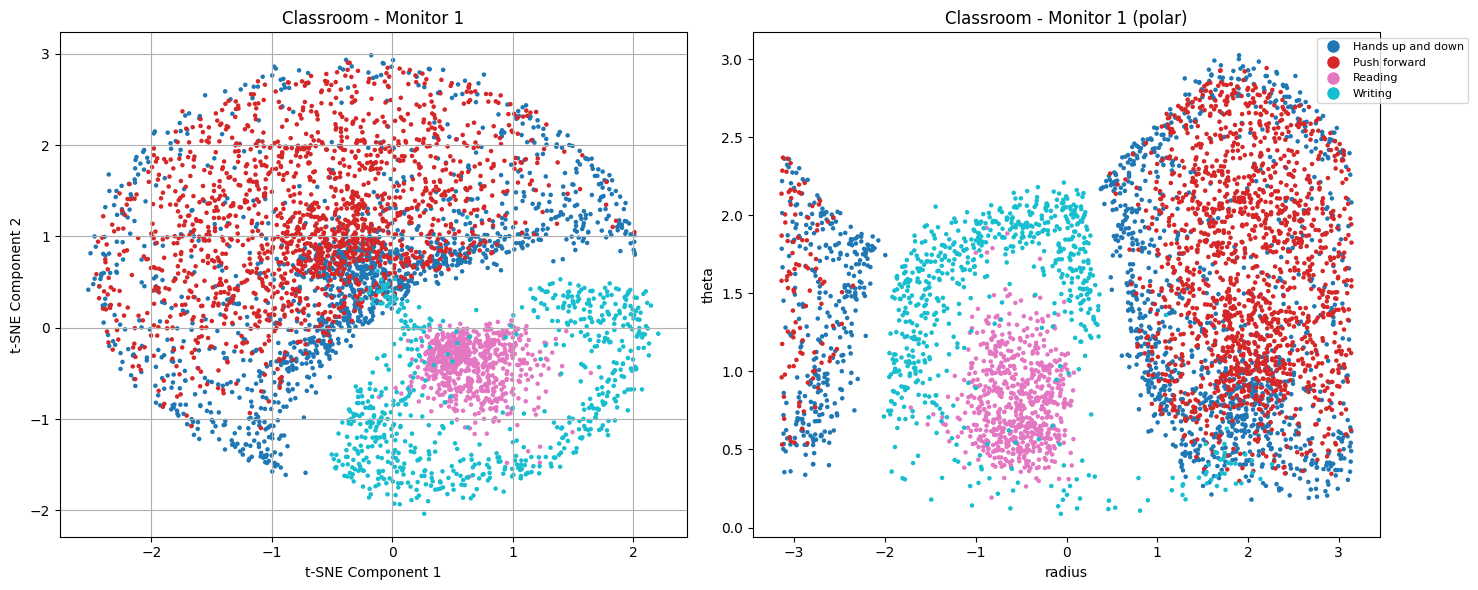

In [54]:
subset = get_subset(csv_summary, monitors=['m1'], environments=['Classroom'])
plot_tsne(subset, title='Classroom - Monitor 1', output_file='SAIDAS/08-tsne-classroom-m1.png', perplexity=50)

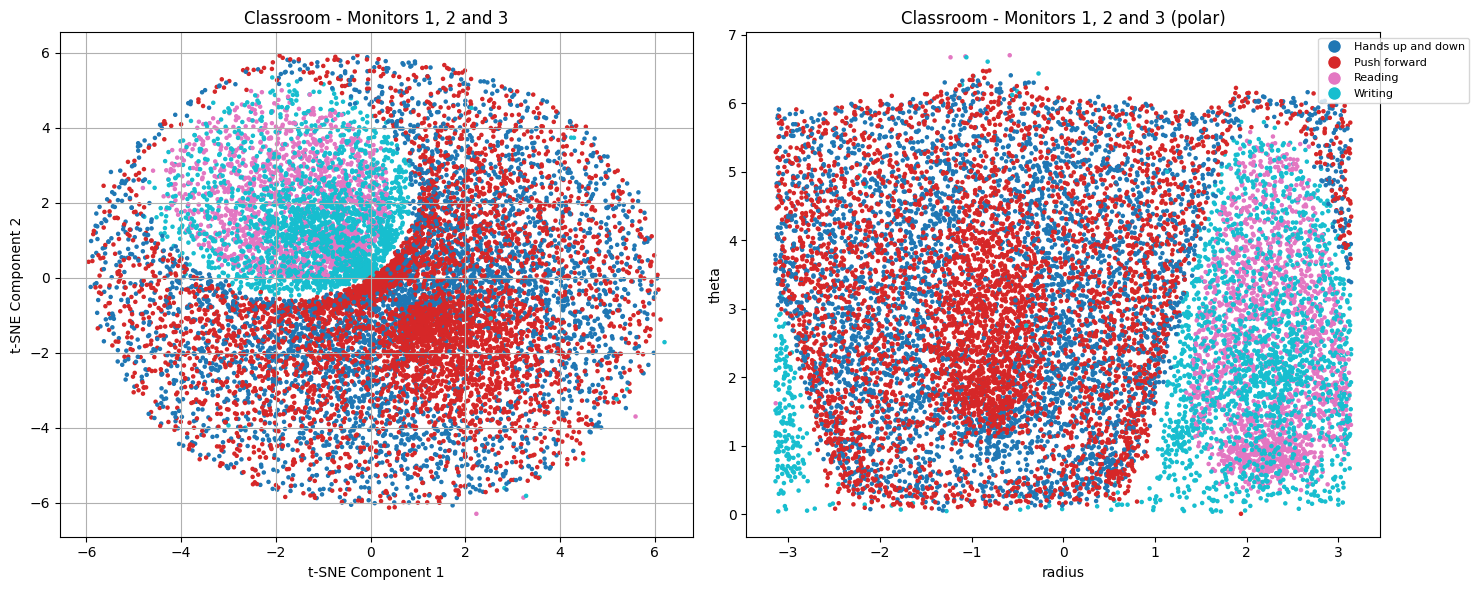

In [55]:
subset = get_subset(csv_summary, environments=['Classroom'])
plot_tsne(subset, title='Classroom - Monitors 1, 2 and 3', output_file='SAIDAS/08-tsne-classroom-m1m2m3.png', perplexity=100)

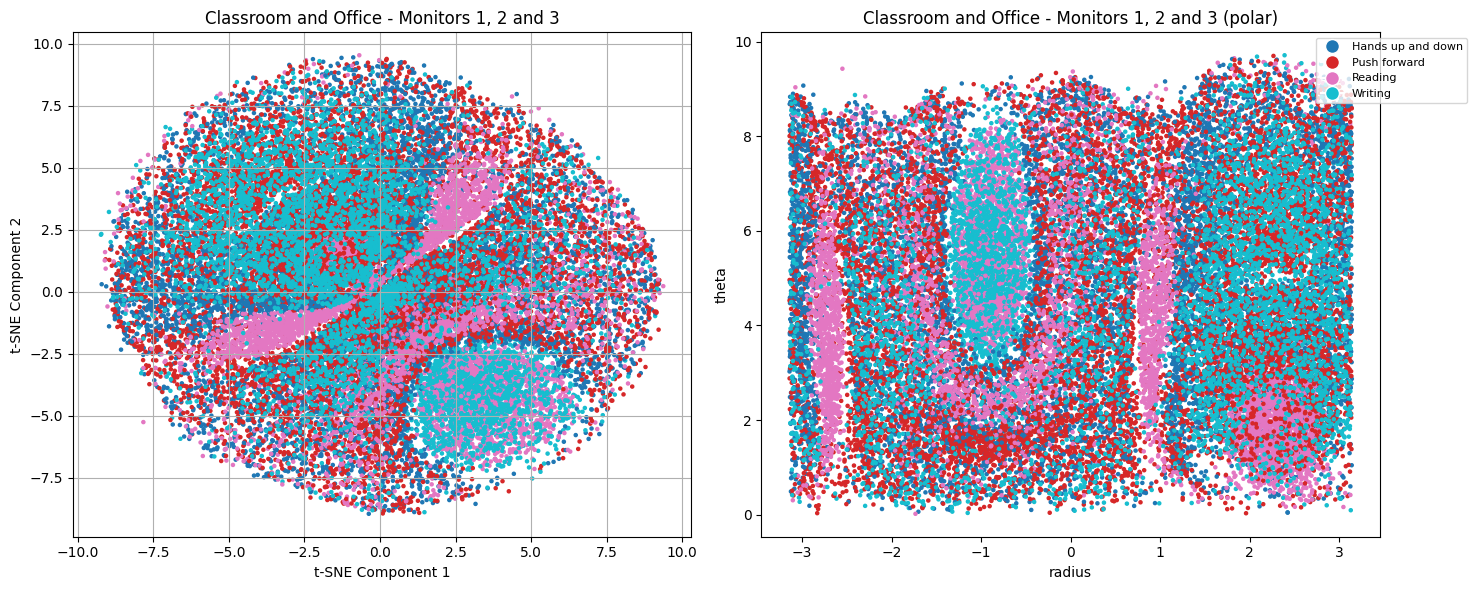

In [56]:
subset = get_subset(csv_summary)
plot_tsne(subset, title='Classroom and Office - Monitors 1, 2 and 3', output_file='SAIDAS/08-tsne-classroom_office-m1m2m3.png', perplexity=100)

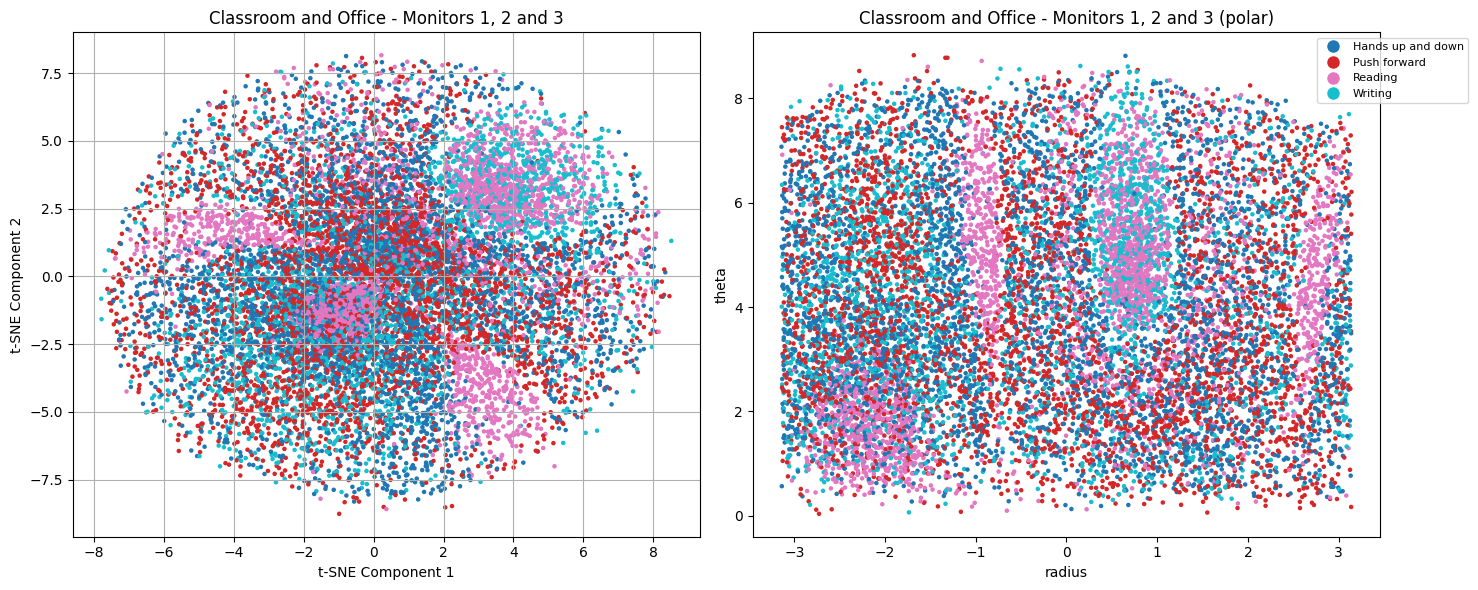

In [8]:
subset = get_subset(csv_summary, samplesize=13000)
plot_tsne(subset, title='Classroom and Office - Monitors 1, 2 and 3', output_file='SAIDAS/08-tsne-classroom_office-m1m2m3-13000pontos.png', perplexity=50)

----
# UMAP


In [40]:
import umap
import umap.plot

In [51]:
def plot_umap(subset, title='', output_file=f'SAIDAS/08-umap-output.png', n_neighbors=15, min_dist=0.1):
  X = np.zeros((len(subset), 50 * 242 * 2))

  for i in range(len(subset)):
    csv_path = subset.iloc[i]['csv_file_path']
    sample_file_path = subset.iloc[i]['filename']
    base_folder = os.path.dirname(csv_path)
    sample_file_path = os.path.join(base_folder, sample_file_path)
    data = scipy.io.loadmat(sample_file_path)['csi_mon']
    real_part = np.real(data)
    imag_part = np.imag(data)
    X[i] = np.concatenate((real_part.flatten(), imag_part.flatten()))

  X = X.astype(np.float32)
  labels = subset['activity'].tolist()

  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_

  mapper = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit(X)
  umap.plot.points(mapper, labels=class_names[numeric_labels], cmap='tab10')
  plt.title(title)
  plt.savefig(output_file, dpi=300, bbox_inches='tight')

/home/diogo/miniconda3/envs/simwisense/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


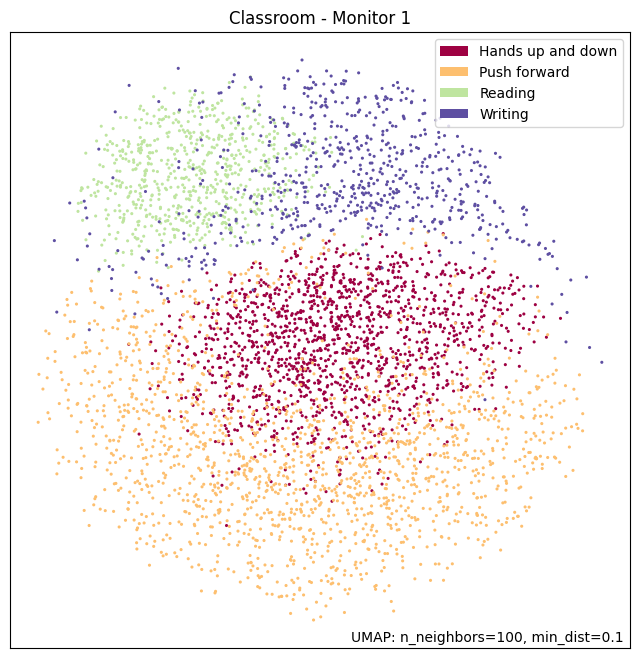

In [53]:

subset = get_subset(csv_summary, monitors=['m1'], environments=['Classroom'])
plot_umap(subset, title='Classroom - Monitor 1', output_file='SAIDAS/08-umap-classroom-m1.png', n_neighbors=100)

/home/diogo/miniconda3/envs/simwisense/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


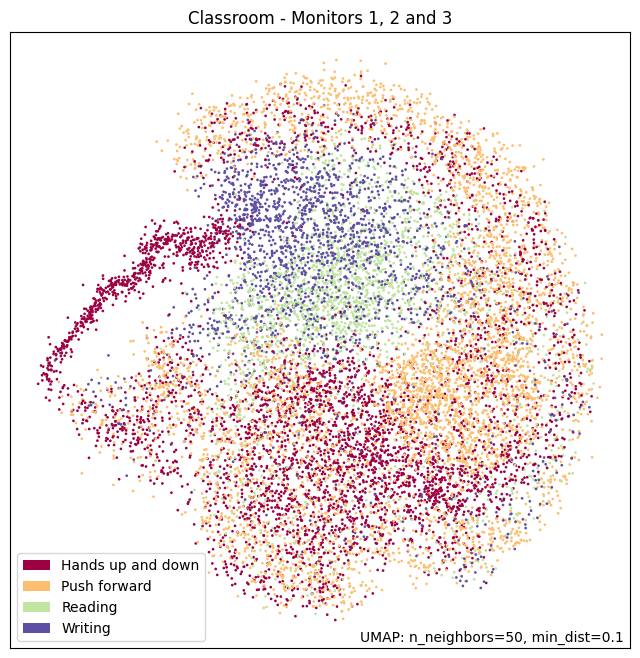

In [57]:
subset = get_subset(csv_summary, environments=['Classroom'])
plot_umap(subset, title='Classroom - Monitors 1, 2 and 3', output_file='SAIDAS/08-umap-classroom-m1m2m3.png', n_neighbors=50)

/home/diogo/miniconda3/envs/simwisense/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


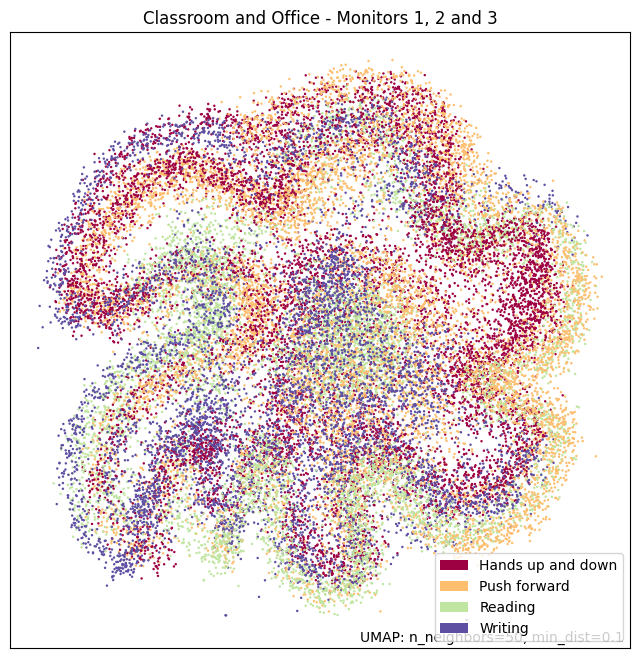

In [58]:
subset = get_subset(csv_summary)
plot_umap(subset, title='Classroom and Office - Monitors 1, 2 and 3', output_file='SAIDAS/08-umap-classroom_office-m1m2m3.png', n_neighbors=50)